TASK 1

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import json
import os
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Load ResNet-34 model
model = torchvision.models.resnet34(weights="IMAGENET1K_V1").to(device).eval()

In [6]:
# 🔁 Define normalization (ImageNet standard)
mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

In [7]:
# Load dataset
dataset_path = "./TestDataSet"
dataset = torchvision.datasets.ImageFolder(dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)


In [12]:

# 📑 Load mapping: folder index → ImageNet class index (from labels_list.json)
with open(os.path.join(dataset_path, "labels_list.json")) as f:
    label_map = json.load(f)
folder_to_imagenet_idx = {i: int(item.split(":")[0]) for i, item in enumerate(label_map)}


In [13]:
# 🔍 Evaluate
top1_correct = 0
top5_correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in tqdm(dataloader, desc="🔎 Evaluating ResNet-34"):
        imgs = imgs.to(device)
        # Map folder index → ImageNet class index
        true_labels = torch.tensor([folder_to_imagenet_idx[int(lbl)] for lbl in labels]).to(device)
        outputs = model(imgs)
        _, preds = outputs.topk(5, dim=1)

        top1_correct += (preds[:, 0] == true_labels).sum().item()
        top5_correct += sum(true_labels[i].item() in preds[i] for i in range(len(true_labels)))
        total += len(true_labels)

top1_acc = top1_correct / total * 100
top5_acc = top5_correct / total * 100

print(f"✅ Task 1 | Top-1 Accuracy: {top1_acc:.2f}%")
print(f"✅ Task 1 | Top-5 Accuracy: {top5_acc:.2f}%")

🔎 Evaluating ResNet-34: 100%|██████████| 16/16 [00:16<00:00,  1.01s/it]

✅ Task 1 | Top-1 Accuracy: 76.00%
✅ Task 1 | Top-5 Accuracy: 94.00%


TASK 2

In [14]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
import os, json
import matplotlib.pyplot as plt
from tqdm import tqdm

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
# Load pretrained ResNet-34
model = models.resnet34(weights="IMAGENET1K_V1").to(device).eval()

In [17]:
# Transform & dataset
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

dataset_path = "./TestDataSet"
dataset = datasets.ImageFolder(dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [18]:

# Label mapping
with open(os.path.join(dataset_path, "labels_list.json")) as f:
    label_map = json.load(f)
folder_to_imagenet = {i: int(entry.split(":")[0]) for i, entry in enumerate(label_map)}

In [19]:
# FGSM Attack Function
def fgsm_attack(image, label, epsilon=0.02):
    image.requires_grad = True
    output = model(image)
    loss = F.cross_entropy(output, label)
    model.zero_grad()
    loss.backward()
    grad = image.grad.data.sign()
    perturbed = torch.clamp(image + epsilon * grad, 0, 1)
    return perturbed.detach()

# Generate FGSM adversarial examples
adv_images = []
adv_labels = []
misclassified = 0
os.makedirs("examples_fgsm", exist_ok=True)

for idx, (img, label) in enumerate(tqdm(dataloader, desc="⚡ FGSM Attack")):
    img = img.to(device)
    true_label = torch.tensor([folder_to_imagenet[int(label)]], device=device)

    # Predict original
    pred = torch.argmax(model(img), dim=1)
    adv_img = fgsm_attack(img, true_label, epsilon=0.02)
    adv_pred = torch.argmax(model(adv_img), dim=1)

    # Save if misclassified
    if adv_pred.item() != true_label.item() and misclassified < 5:
        orig_img = img.squeeze(0).cpu().detach()
        pert_img = adv_img.squeeze(0).cpu().detach()

        # Visualize
        plt.figure(figsize=(6, 3))
        plt.subplot(1, 2, 1)
        plt.imshow(orig_img.permute(1, 2, 0).mul(torch.tensor(std)).add(torch.tensor(mean)).clamp(0, 1).numpy())
        plt.title(f"Original (Label: {true_label.item()})")
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.imshow(pert_img.permute(1, 2, 0).mul(torch.tensor(std)).add(torch.tensor(mean)).clamp(0, 1).numpy())
        plt.title(f"FGSM (Pred: {adv_pred.item()})")
        plt.axis("off")
        plt.tight_layout()
        plt.savefig(f"examples_fgsm/misclassified_{idx}.png")
        plt.close()
        misclassified += 1

    adv_images.append(adv_img.squeeze(0).cpu())
    adv_labels.append(true_label.item())

⚡ FGSM Attack: 100%|██████████| 500/500 [00:49<00:00, 10.08it/s]


In [ ]:
# Save adversarial test set
adv_tensor = torch.stack(adv_images)
label_tensor = torch.tensor(adv_labels)
torch.save((adv_tensor, label_tensor), "adversarial_testset_1.pt")
print("✅ Saved Adversarial Test Set 1")

✅ Saved Adversarial Test Set 1 (FGSM)


In [ ]:

# Evaluate performance
loader = DataLoader(TensorDataset(adv_tensor, label_tensor), batch_size=32)
top1 = top5 = total = 0

with torch.no_grad():
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        _, preds = outputs.topk(5, dim=1)
        top1 += (preds[:, 0] == y).sum().item()
        top5 += sum(y[i].item() in preds[i] for i in range(len(y)))
        total += len(y)

top1_acc = top1 / total * 100
top5_acc = top5 / total * 100

print(f"⚠️ FGSM Top-1 Accuracy: {top1_acc:.2f}%")
print(f"⚠️ FGSM Top-5 Accuracy: {top5_acc:.2f}%")

⚠️ FGSM Top-1 Accuracy: 23.20%
⚠️ FGSM Top-5 Accuracy: 46.80%


Task 3

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import os


In [17]:
# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet34(weights="IMAGENET1K_V1").to(device).eval()

In [20]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os, json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ImageNet normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load test set
dataset_path = "./TestDataSet"
dataset = datasets.ImageFolder(dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Label mapping from folder → ImageNet ID
with open(os.path.join(dataset_path, "labels_list.json")) as f:
    label_map = json.load(f)
folder_to_imagenet = {i: int(entry.split(":")[0]) for i, entry in enumerate(label_map)}

# Build and store dataset
images, labels = [], []
for x, y in dataloader:
    images.append(x.squeeze(0))
    labels.append(folder_to_imagenet[int(y)])

torch.save((torch.stack(images), torch.tensor(labels)), "original_data.pt")
print("✅ Saved: original_data.pt")

✅ Saved: original_data.pt


In [21]:
# Load original clean dataset (from Task 1)
original_images, original_labels = torch.load("original_data.pt")
original_loader = DataLoader(TensorDataset(original_images, original_labels), batch_size=1, shuffle=False)

/var/folders/k7/5z9ffk3510dgxcdhs6bkjt0c0000gn/T/ipykernel_91457/3660758073.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_images, original_labels = torch.load

In [23]:
# PGD Attack parameters
epsilon = 0.02
alpha = 0.005
num_iter = 10
os.makedirs("pgd_visuals", exist_ok=True)

def pgd_attack(image, label, epsilon, alpha, num_iter):
    image = image.clone().detach().to(device)
    label = label.to(device)
    original = image.clone().detach()
    perturbed = (image + torch.empty_like(image).uniform_(-epsilon, epsilon)).detach().requires_grad_(True)

    for _ in range(num_iter):
        output = model(perturbed.unsqueeze(0))
        loss = F.cross_entropy(output, label.unsqueeze(0))
        model.zero_grad()
        loss.backward()

        grad = perturbed.grad.data.sign()
        perturbed = perturbed + alpha * grad
        perturbed = torch.max(torch.min(perturbed, original + epsilon), original - epsilon)
        perturbed = perturbed.detach().requires_grad_(True)

    return perturbed.detach()

🔥 PGD Attack: 100%|██████████| 500/500 [07:13<00:00,  1.15it/s]  


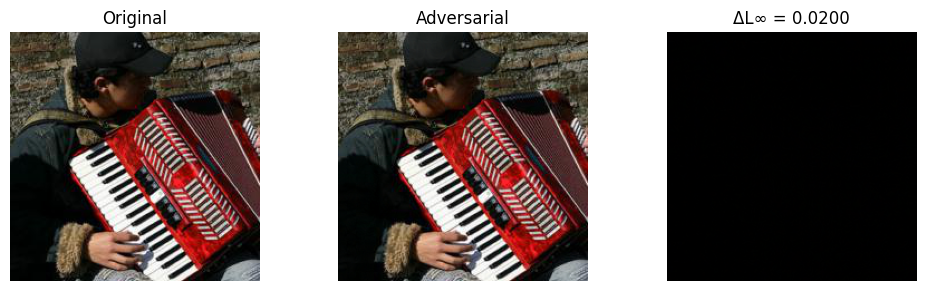

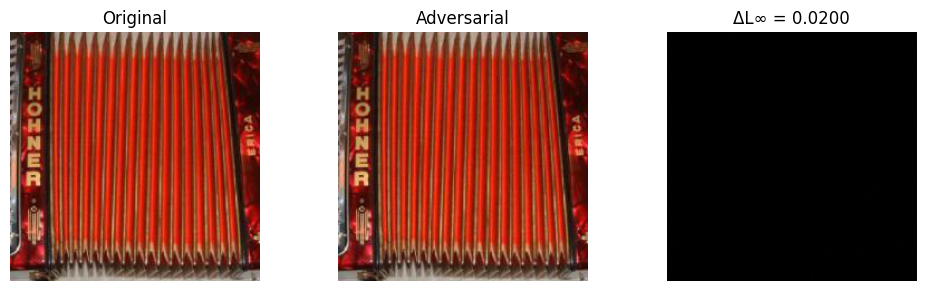

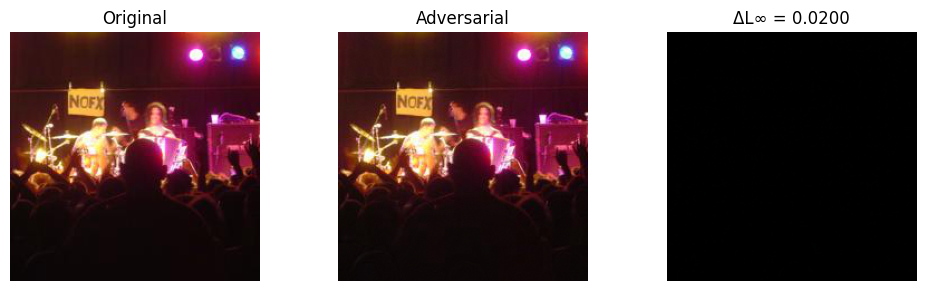

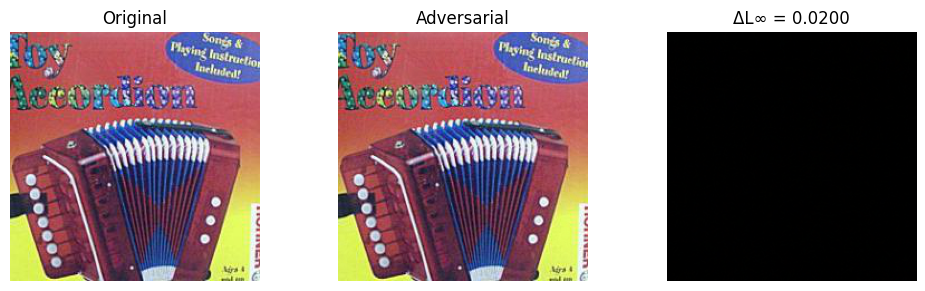

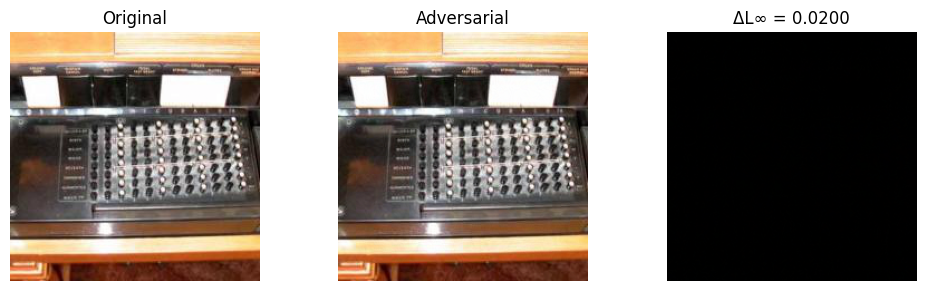

In [24]:
# Run PGD on dataset
adv2_images = []
adv2_labels = []
visualized = 0

for i, (img, lbl) in enumerate(tqdm(dataloader, desc="🔥 PGD Attack")):
    img = img.squeeze(0)
    lbl = lbl.squeeze(0)
    adv_img = pgd_attack(img, lbl, epsilon, alpha, num_iter)

    adv2_images.append(adv_img.cpu())
    adv2_labels.append(lbl.cpu())

    # Visualize 3-5 examples
    if visualized < 5:
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        orig_vis = (img.cpu() * std + mean).clamp(0, 1).permute(1, 2, 0).numpy()
        adv_vis = (adv_img.cpu() * std + mean).clamp(0, 1).permute(1, 2, 0).numpy()
        diff = (adv_img - img).abs().max().item()

        plt.figure(figsize=(10, 3))
        plt.subplot(1, 3, 1)
        plt.imshow(orig_vis)
        plt.title("Original")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(adv_vis)
        plt.title("Adversarial")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow((adv_vis - orig_vis).clip(0, 1), cmap='inferno')
        plt.title(f"ΔL∞ = {diff:.4f}")
        plt.axis("off")

        plt.tight_layout()
        plt.savefig(f"pgd_visuals/pgd_{i}.png")
        visualized += 1

In [25]:
# Save Adversarial Test Set 2
adv2_images = torch.stack(adv2_images)
adv2_labels = torch.tensor(adv2_labels)
torch.save((adv2_images, adv2_labels), "adversarial_testset_2.pt")

In [26]:
# Evaluate PGD performance
adv_loader = DataLoader(TensorDataset(adv2_images, adv2_labels), batch_size=32)
top1, top5, total = 0, 0, 0

with torch.no_grad():
    for inputs, targets in adv_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, top5_preds = outputs.topk(5, dim=1)

        top1 += (top5_preds[:, 0] == targets).sum().item()
        top5 += sum([targets[i].item() in top5_preds[i] for i in range(len(targets))])
        total += targets.size(0)

# Report accuracy
top1_acc = top1 / total * 100
top5_acc = top5 / total * 100

print(f"🔥 PGD Top-1 Accuracy: {top1_acc:.2f}%")
print(f"🔥 PGD Top-5 Accuracy: {top5_acc:.2f}%")

🔥 PGD Top-1 Accuracy: 0.00%
🔥 PGD Top-5 Accuracy: 0.00%


TASK 4

In [34]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import random

In [29]:
# Load pretrained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet34(weights='IMAGENET1K_V1').to(device).eval()

In [30]:
# Load clean data
original_images, original_labels = torch.load("original_data.pt")
dataloader = DataLoader(TensorDataset(original_images, original_labels), batch_size=1)


/var/folders/k7/5z9ffk3510dgxcdhs6bkjt0c0000gn/T/ipykernel_91457/2228205566.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_images, original_labels = torch.load

In [35]:
def patch_pgd_attack(img, label, eps=0.5, alpha=0.05, iters=10, patch_size=32):
    model.eval()
    C, H, W = img.shape
    img = img.to(device)
    label = label.to(device)

    orig = img.clone().detach()
    
    # Random patch
    x0 = torch.randint(0, W - patch_size + 1, (1,)).item()
    y0 = torch.randint(0, H - patch_size + 1, (1,)).item()

    perturbed = orig.clone().detach()
    perturbed.requires_grad = True  # Ensure it's a leaf tensor

    for _ in range(iters):
        outputs = model(perturbed.unsqueeze(0))
        loss = F.cross_entropy(outputs, label.unsqueeze(0))

        model.zero_grad()
        if perturbed.grad is not None:
            perturbed.grad.zero_()
        loss.backward()

        # Make sure grad is not None
        if perturbed.grad is None:
            raise ValueError("Gradient is None. Make sure perturbed.requires_grad = True before backward()")

        grad_sign = perturbed.grad.detach().sign()

        # Update patch only
        patch_grad = grad_sign[:, y0:y0+patch_size, x0:x0+patch_size]
        patch = perturbed[:, y0:y0+patch_size, x0:x0+patch_size] + alpha * patch_grad
        patch = torch.clamp(patch, orig[:, y0:y0+patch_size, x0:x0+patch_size] - eps,
                                   orig[:, y0:y0+patch_size, x0:x0+patch_size] + eps)

        # Replace patch in the full image
        new_img = perturbed.detach().clone()
        new_img[:, y0:y0+patch_size, x0:x0+patch_size] = patch.detach()
        perturbed = new_img.clone().detach().requires_grad_()

    return perturbed.detach()

🧨 Patch Attack: 100%|██████████| 500/500 [04:30<00:00,  1.85it/s]


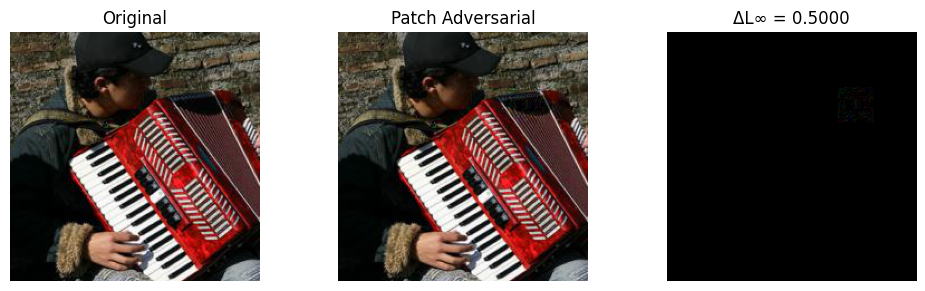

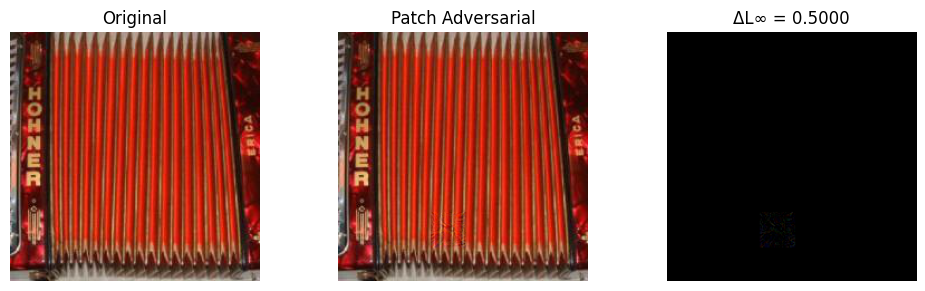

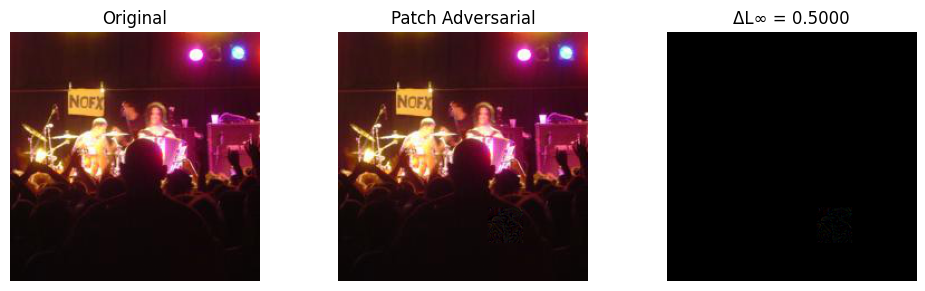

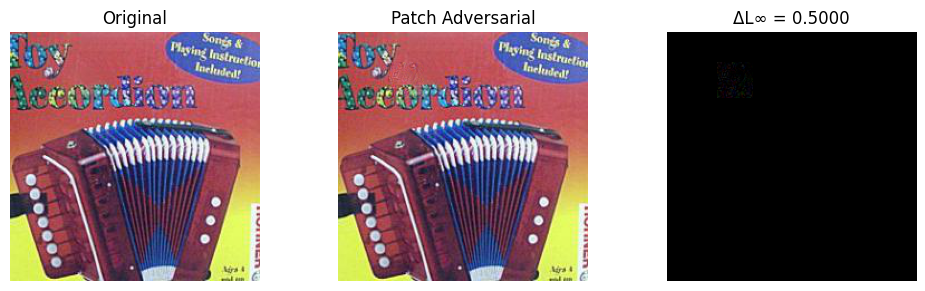

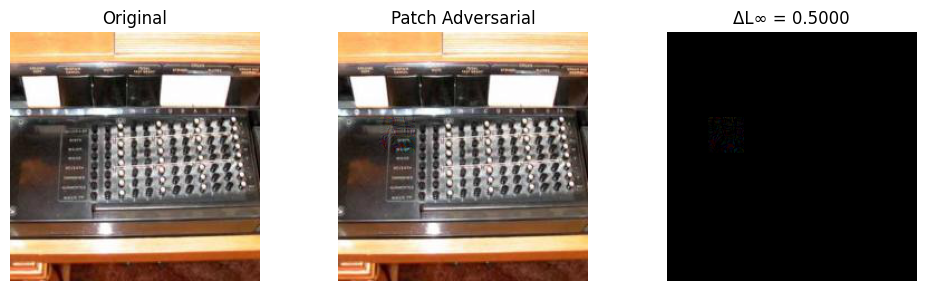

In [36]:
# Run patch attack
adv3_images = []
adv3_labels = []
visualized = 0

for i, (img, lbl) in enumerate(tqdm(dataloader, desc="🧨 Patch Attack")):
    img = img.squeeze(0)
    lbl = lbl.squeeze(0)
    adv_img = patch_pgd_attack(img, lbl)

    adv3_images.append(adv_img.cpu())
    adv3_labels.append(lbl.cpu())

    # Visualize first 5
    if visualized < 5:
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        orig_vis = (img.cpu() * std + mean).clamp(0, 1).permute(1, 2, 0).numpy()
        adv_vis = (adv_img.cpu() * std + mean).clamp(0, 1).permute(1, 2, 0).numpy()
        diff = (adv_img - img).abs().max().item()

        plt.figure(figsize=(10, 3))
        plt.subplot(1, 3, 1)
        plt.imshow(orig_vis)
        plt.title("Original")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(adv_vis)
        plt.title("Patch Adversarial")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow((adv_vis - orig_vis).clip(0, 1), cmap='inferno')
        plt.title(f"ΔL∞ = {diff:.4f}")
        plt.axis("off")

        plt.tight_layout()
        plt.savefig(f"patch_attack_visuals/patch_{i}.png")
        visualized += 1

In [37]:
# Save adversarial test set 3
adv3_images = torch.stack(adv3_images)
adv3_labels = torch.tensor(adv3_labels)
torch.save((adv3_images, adv3_labels), "adversarial_testset_3.pt")

In [38]:
# Evaluate
adv_loader3 = DataLoader(TensorDataset(adv3_images, adv3_labels), batch_size=32)
top1, top5, total = 0, 0, 0

with torch.no_grad():
    for inputs, targets in adv_loader3:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, top5_preds = outputs.topk(5, dim=1)

        top1 += (top5_preds[:, 0] == targets).sum().item()
        top5 += sum([targets[i].item() in top5_preds[i] for i in range(len(targets))])
        total += targets.size(0)

# Print results
top1_acc = top1 / total * 100
top5_acc = top5 / total * 100
print(f"🧨 Patch Attack Top-1 Accuracy: {top1_acc:.2f}%")
print(f"🧨 Patch Attack Top-5 Accuracy: {top5_acc:.2f}%")

🧨 Patch Attack Top-1 Accuracy: 45.60%
🧨 Patch Attack Top-5 Accuracy: 80.40%
